# Kaggle Tabular Playground Series - Mar 2022
Forecasting 12 hours of traffic flow of roadways given basic spacio-temporal information such as time, coordinates and roadway direction.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


In [55]:
def raw_to_df(csv_path):
    return pd.read_csv(f"data/{csv_path}", index_col=0)


# convert csv files to dataframes
submission = raw_to_df("sample_submission.csv")
test = raw_to_df("test.csv")
train = raw_to_df("train.csv")
congestion = train["congestion"]

# convert values to pd.datetime objects
train["time"] = pd.to_datetime(train["time"])
test["time"] = pd.to_datetime(test["time"])


In [5]:
test.head()


,time,x,y,direction
row_id,,,,
848835,1991-09-30 12:00:00,0,0,EB
848836,1991-09-30 12:00:00,0,0,NB
848837,1991-09-30 12:00:00,0,0,SB
848838,1991-09-30 12:00:00,0,1,EB
848839,1991-09-30 12:00:00,0,1,NB


## Train dataset exploration

Train time series ranges from April to September, 65 observations for each day.

In [6]:
num_rows = len(train)
num_rows


848835

In [7]:
# first 5 rows
train.head()


,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01,0,0,EB,70
1,1991-04-01,0,0,NB,49
2,1991-04-01,0,0,SB,24
3,1991-04-01,0,1,EB,18
4,1991-04-01,0,1,NB,60


In [8]:
# values for each column
for col in train.columns:
    print(f"Col_name: {col}")
    print(train[col].unique(), "\n")


Col_name: time
['1991-04-01T00:00:00.000000000' '1991-04-01T00:20:00.000000000'
 '1991-04-01T00:40:00.000000000' ... '1991-09-30T11:00:00.000000000'
 '1991-09-30T11:20:00.000000000' '1991-09-30T11:40:00.000000000'] 

Col_name: x
[0 1 2] 

Col_name: y
[0 1 2 3] 

Col_name: direction
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE'] 

Col_name: congestion
[ 70  49  24  18  60  58  26  31  46  29  16  21  47  51  74  43  44  52
  32  77  39  63  53  28  54  41  37  15  61  65  22  34  45  42  50  36
  64  30  55  57  40  33  17  48  71  69  10  67  80  91  35  56  59  38
  78  27  79  20  83  62  25  19   7  82  75  76  85 100   2  88  12  89
  73  11  81  72  13  84  23  92  14   6   8   9  66  68   5   0  95  87
  90  97  86  96  94   4  93   3   1  98  99] 



<Figure size 1152x432 with 0 Axes>

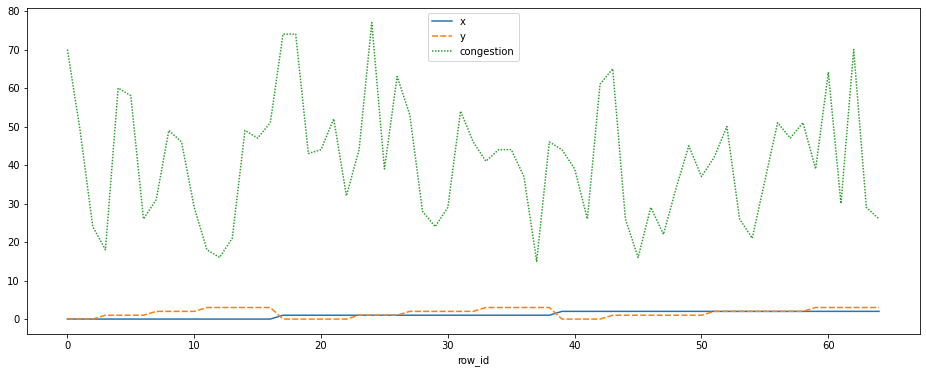

In [9]:
plt.figure(figsize=(16, 6))
first_day = train.iloc[:65, :]
sns.lineplot(data=first_day)


In [10]:
print("Min_train_date:", train.time.min())
print("Max_train_date:", train.time.max())
print("Min_test_date", test.time.min())
print("Max_test_date", test.time.max())
test_time = test.time.max() - test.time.min()
test_time


Min_train_date: 1991-04-01 00:00:00
Max_train_date: 1991-09-30 11:40:00
Min_test_date 1991-09-30 12:00:00
Max_test_date 1991-09-30 23:40:00


Timedelta('0 days 11:40:00')

## Feature engineering

In [56]:
# last 11:40 hours from 1991-09-30
val = train.loc[train.time >= "1991-09-30 00:00:00"]

train = train.loc[train.time < "1991-09-30 00:00:00"]

val_x = val.iloc[:, :-1]
val_y = val.congestion


Test data corresponds to 20 minute intervals of 1991-09-30, ranging from 12:00 to 23:40.

In [57]:
for df in [train, test, val_x]:
    df["day_of_week"] = df["time"].map(lambda x: x.dayofweek)
    df["hour"] = df["time"].map(lambda x: x.hour)
    df["minute"] = df["time"].map(lambda x: x.minute)


## Predictions

In [44]:
pred = (
    train.groupby(["x", "y", "direction", "day_of_week", "hour", "minute"])
    .congestion.median()
    .astype(int)
)


In [37]:
pred


x  y  direction  day_of_week  hour  minute
0  0  EB         0            0     0         35
                                    20        35
                                    40        35
                              1     0         35
                                    20        35
                                              ..
2  3  WB         6            22    20        40
                                    40        44
                              23    0         41
                                    20        38
                                    40        39
Name: congestion, Length: 32760, dtype: int64

In [58]:
def predict(row):
    return pred.loc[row.x, row.y, row.direction, row.day_of_week, row.hour, row.minute]


predictions = val_x.apply(predict, axis="columns")

MAE = mean_absolute_error(val_y, predictions)

MAE


6.641025641025641

## Submission

In [71]:
predictions = test.apply(predict, axis='columns')
submission['congestion'] = predictions
submission.to_csv('submission.csv')

! kaggle competitions submit -c tabular-playground-series-mar-2022 -f submission.csv -m "Medianas"

100% 22.9k/22.9k [00:02<00:00, 9.71kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022